# Modified CPPI

Here I am going to implement Constant Proportion Portfolio Insurance(CPPI) and Drawdown Constraints with some modification. One can think CPPI as the theoritical foundation of 60:40 portfolios. In this exercize, I am going to do historical backtesting with changing risk avaersion parameter.

### Basic CPPI :
Floor - below which you do not want your asset to fall
m - multiplier
Cushion : Asset Value - Floor Value
Allocation to Risky Asset : m*Cushion

Floor = 80% and m = 3 gives us 60:40 portfolio.

#### Adjustment to Cushion
Rather than calculating Cushion based on current Asset Value, I am going to calculate Cushion based on Peak Asset Value. This will result in smaller Drawdown and more conservative portfolio.

For more on CPPI, see https://en.wikipedia.org/wiki/Constant_proportion_portfolio_insurance

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy.stats as st
import yfinance as yf
import pandas_datareader.data as web
import datetime

ModuleNotFoundError: No module named 'yfinance'

### Data
For this strategy, we need two asset - risky/agressive and safe/defensive. One can choose which ever they like. For my excercize, I am going to use S&P 500 as my risky/agressive asset simply because it is well known and has long history. For my safe/defensive asset, I am goig to use LBUSTRUU Index. One can use any asset combination they like. 

I am going to use monthly data. But this can also be implemented at other frequencies. 

In [3]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "^GSPC",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "max",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1mo",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
)

print(data.head())

SP500 = pd.DataFrame(data['Close'], columns = ['Close'])
SP500.info()

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Volume
Date                                                          
1927-12-01  17.660000  17.660000  17.660000  17.660000       0
1928-01-01  17.760000  17.760000  17.260000  17.570000       0
1928-02-01  17.530001  17.629999  16.950001  17.260000       0
1928-03-01  17.299999  19.280001  17.299999  19.280001       0
1928-04-01  18.910000  19.750000  18.910000  19.750000       0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1114 entries, 1927-12-01 to 2020-08-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1114 non-null   float64
dtypes: float64(1)
memory usage: 17.4 KB


In [6]:
SP500['Return'] = (SP500['Close']/ SP500['Close'].shift(1)) -1
SP500.dropna(inplace = True)
SP500

,Close,Return
Date,,
1928-01-01,17.570000,-0.005096
1928-02-01,17.260000,-0.017644
1928-03-01,19.280001,0.117034
1928-04-01,19.750000,0.024378
1928-05-01,20.000000,0.012658
...,...,...
2020-05-01,3044.310059,0.045282
2020-06-01,3100.290039,0.018388
2020-07-01,3271.120117,0.055101


In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize = (12, 6))
ax2 = ax1.twinx()


ax1.plot(SP500['Close'], color = "blue", label = 'Price') 
ax2.plot(SP500['Return'], 'k:', color = "c", label = 'Monthly Return')
ax2.axhline(y = 0, color = "black")

ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2.set_ylabel('Monthly Return')
ax1.set_title('S&P 500')
#ax1.legend(fontsize=10)
#ax2.legend(fontsize=10)
# ask matplotlib for the plotted objects and their labels
#lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines + lines2, labels + labels2, loc=0)

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.show()

In [ ]:
print(SP500.head())

#### LBUSTRUU Index 

In [ ]:
bond = pd.read_csv("bond.csv", index_col = "Date", parse_dates=True)

In [ ]:
print(bond.head())
print(bond.info())

In [ ]:
bond.columns = ['Bond_Close']
bond['Return'] = (bond['Bond_Close']/ bond['Bond_Close'].shift(1)) -1
bond.dropna(inplace = True)

In [ ]:
fig, ax1 = plt.subplots(figsize = (12, 6))
ax2 = ax1.twinx()


ax1.plot(bond['Bond_Close'], color = "blue", label = 'Price') 
ax2.plot(bond['Return'], 'k:', color = "c", label = 'Monthly Return')
ax2.axhline(y = 0, color = "black")

ax1.set_xlabel('Date')
ax1.set_ylabel('Index')
ax2.set_ylabel('Monthly Return')
ax1.set_title('Bloomberg Barclays US Agg Total Return Value Unhedged USD( LBUSTRUU Index)')
#ax1.legend(fontsize=10)
#ax2.legend(fontsize=10)
# ask matplotlib for the plotted objects and their labels
#lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines + lines2, labels + labels2, loc=0)

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.show()

Note - 
1. So far I have one risky-on asset and one risk-off asset. Risky asset has a longer history. It would have helped if I could have access to some risk-off asset with longer history. But this the one with longest history I have access to. 

2. Also notice that SP500 is not total return index, where as LBUSTRUU is. Unfortunately, Total return equivalent of SP500 has much shorter history. For now, I am  going to use these two indices, although they clearly have shortcomings.

In [ ]:
def run_cppi(risky_r, safe_r = None, m = 3, initW = 1000, floor = 0.8, rf = 0.05, drawdown = None):
    """
    
    """
    # Set-up CPPI Parameters
    dates = risky_r.index
    account_value = initW
    peak = initW
    floor_value = initW*floor
    
    if isinstance(risky_r, pd.Series):
        risky_r = pd.DataFrame(risky_r, columns = ["R"])
    
    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r[:] = rf/12
                  
    account_hist = pd.DataFrame().reindex_like(risky_r)
    floor_hist = pd.DataFrame().reindex_like(risky_r)
    cushion_hist = pd.DataFrame().reindex_like(risky_r)
    risky_w_hist = pd.DataFrame().reindex_like(risky_r)   
    
    for step in range(len(dates)):
        if drawdown is not None:
            # Floor Value changes based on Peak and Drawdown
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1 - drawdown)
            
        cushion = (account_value - floor_value)/account_value
        risky_w = np.minimum(1, m*cushion)
        risky_w = np.maximum(0, risky_w)
        safe_w = 1 - risky_w

        risky_allocation = account_value*risky_w
        safe_allocation = account_value*safe_w
        account_value = risky_allocation*(1 + risky_r.iloc[step]) + safe_allocation*(1 + safe_r.iloc[step])

        # save the values in Data Frame
        cushion_hist.iloc[step] = cushion
        risky_w_hist.iloc[step] = risky_w
        account_hist.iloc[step] = account_value
        floor_hist.iloc[step] = floor_value
    
    risky_wealth = initW*(1 + risky_r).cumprod()
    cppi_results = {
        "Wealth" : account_hist,
        "Risky Wealth" : risky_wealth,
        "Risk Budget" : cushion_hist,
        "Risk Allocation" : risky_w_hist,
        "Multiplier" : m,
        "Initial Wealth" : initW,
        "Floor" : floor_hist,
        "Risky Return" : risky_r,
        "Safe Return" : safe_r
    }
    return cppi_results


### Time-varying Multiplier

Rather than using constant multipler, in this exercize, I am going to use time varying multiplier. Multiplier signifies risk aversion. Higher value of m implies bigger position in risky asset. Assuming 40 years portfolio, I am going to assign large value of m in the begining with higher allocation to risky asset. With time, value of m should approch 0, with no allocation to risky asset in the 40th year.

In [2]:
c = -np.log(.25)/10 # Result in multiplier to be 3 at year 30 [4*(1-exp(-c*(40-30))) = 3]
multi = pd.DataFrame(np.arange(1,41,1), columns = ['Year'])
multi['m'] = 4*(1-np.exp(-c*(40-multi['Year'])))
multi = multi.set_index('Year')

0.13862943611198905
             m
Year          
1     3.982052
2     3.979383
3     3.976317
4     3.972795
5     3.968750


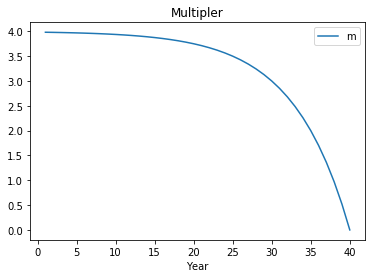

In [3]:
print(c)
print(multi.head())
multi.plot(title = "Multipler")

In [5]:
def getMultiplier(alpha = 0.14, t = 40):
    # Generate time-varying multiplier for a 40 year portfolio
    # alpha is defined such that multiplier to be 3 at year 30 : 4*(1-exp(-c*(40-30))) = 3
    multi = pd.DataFrame(np.arange(1,(t+1),1), columns = ['Year'])
    multi['m'] = 4*(1-np.exp(-c*(t-multi['Year'])))
    multi = multi.set_index('Year')
    return(multi)

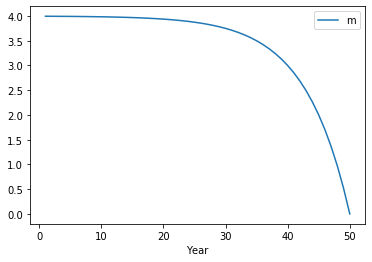

In [8]:
getMultiplier(alpha = 0.1, t = 50).plot(title = "Multiplier")